# Data Processing

 **Wenrui Wu**, **Huaying Qiu**

**2025-12-06**

This tutorial will introduce you to the standard data processing pipeline used in JiangLab. In short, the pipeline has five main components:

1. Nuclear channel filter to filter out “fake” cells with minimal nucleus signal
2. Nuclear channel normalization to decrease the core-to-core variance if any
3. Arcsinh transformation to make the data less skewed
4. Trim off extreme/outliers at the lower and upper end of marker distribution
5. Transform the data to a range of [0,1] by quantile/percentile

In the following sections, these steps will be explored in detail.

Tutorial in R: https://github.com/SizunJiangLab/Tutorials/tree/main/CODEX/Data_Preprocessing

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from codex_preprocessing.preprocessing import (
    ExtremeCutoff,
    _downsample_cells,
    arcsinh_transformation,
    combine_csv_data,
    nucleus_signal_normalization,
    plot_arcsinh_transformation,
    plot_quantile_normalization,
    print_processing_history,
    quantile_normalization,
)

(Running pyCODEX2 0.1.1)
2025-12-06 21:57:51


## Data Preparation

Using `segmentation` module of the `pycodex2`, generate cell-level data from raw CODEX images.

In each folder of a region (e.g., core in TMA data), there are multiple subfolders, each of which contains the results of a specific segmentation. Each subfolder contains the following files:

In [2]:
root_dir = Path(
    "/mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/20250116_ometiff/"
)
region_dirs = list(root_dir.glob("*RCC*"))

print(f"Files in region directory: {region_dirs[0]}")
for f in region_dirs[0].iterdir():
    print(f"    - {f.name}")

print("\nFiles in segmentation directory:")
for f in (region_dirs[1] / "20250125_whole_cell").glob("*"):
    print(f"    - {f.name}")

Files in region directory: /mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/20250116_ometiff/RCC-TMA001(reg4x3)-dst=reg001-src=reg001
    - RCC-TMA001(reg4x3)-dst=reg001-src=reg001.ome.tiff
    - 20250125_whole_cell
    - 20250207_whole_cell

Files in segmentation directory:
    - segmentation.log
    - parameter_segmentation.json
    - segmentation_mask.tiff
    - segmentation_markers.ome.tiff
    - data.csv
    - dataScaleSize.csv
    - segmentation_mask.geojson


In this step, we will read the `dataScaleSize.csv` file for each region and combine them into a single `AnnData` object for further processing. The `dataScaleSize.csv` file contains the cell-level data, including protein marker intensities and other metadata such as cell size and centroid coordinates.

You need to specify the column names for markers (which will be stored in the `X` attribute), and the rest of the columns will be treated as metadata (which will be stored in the `obs` attribute).

In [3]:
root_dir = Path(
    "/mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/20250116_ometiff/"
)
region_dirs = list(root_dir.glob("*RCC*"))

# List of all `dataScaleSize.csv` files
data_fs = [
    region_dir / "20250125_whole_cell" / "dataScaleSize.csv"
    for region_dir in region_dirs
]

print("List of dataScaleSize.csv files:")
for i in range(3):
    print(f"    - {data_fs[i]}")

# List of identifiers for each region
data_ids = [region_dir.name for region_dir in region_dirs]

print("\nList of region identifiers:")
for i in range(3):
    print(f"    - {data_ids[i]}")

# List of protein marker column names
marker_names = [
    "DAPI",
    "CD45",
    "CD3e",
    "CD8",
    "CD4",
    "CD45RO",
    "CD45RA",
    "CD69",
    "CD57",
    "CD56",
    "FoxP3",
    "CD28",
    "CD86",
    "T-bet",
    "TCF1_7",
    "IFN-y",
    "GranzymeB",
    "Tox_Tox2",
    "Tim-3",
    "PD-1",
    "LAG-3",
    "CD20",
    "CD138",
    "TREM2",
    # "CD68",  # Missing in some regions
    "CD163",
    "CD16",
    "CD11b",
    "CD11c",
    "C1Q",
    "MPO",
    "IDO-1",
    "PDL1",
    "CA9",
    "Cytokeratin",
    "HLA1",
    "Ki-67",
    "P53",
    "CD31",
    "Podoplanin",
    "aSMA",
    "NaKATP",
    "VDAC1",
    "ATP5A",
    "GLUT1",
    "G6PD",
]

# Dictionary for renaming columns, if needed
# With keys as original names and values as new names
rename_dict = {
    "cellLabel": "cell_id",
    "cellSize": "cell_size",
    "X_cent": "x_cent",
    "Y_cent": "y_cent",
}

# Column name for cell identifier and batch (in this case, core) identifier
# Unique ID for each cell is constructed as "{data_id}_c{cell_id}"
col_cell_id = "cell_id"
col_data_id = "core_id"

List of dataScaleSize.csv files:
    - /mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/20250116_ometiff/RCC-TMA001(reg4x3)-dst=reg001-src=reg001/20250125_whole_cell/dataScaleSize.csv
    - /mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/20250116_ometiff/RCC-TMA001(reg3x4)-dst=reg001-src=reg001/20250125_whole_cell/dataScaleSize.csv
    - /mnt/nfs/home/wenruiwu/projects/bidmc-jiang-rcc/output/data/20250116_ometiff/RCC-TMA001(reg4x5)-dst=reg001-src=reg009/20250125_whole_cell/dataScaleSize.csv

List of region identifiers:
    - RCC-TMA001(reg4x3)-dst=reg001-src=reg001
    - RCC-TMA001(reg3x4)-dst=reg001-src=reg001
    - RCC-TMA001(reg4x5)-dst=reg001-src=reg009


In [4]:
adata = combine_csv_data(
    data_fs=data_fs,
    data_ids=data_ids,
    marker_names=marker_names,
    rename_dict=rename_dict,
    col_cell_id=col_cell_id,
    col_data_id=col_data_id,
)

# Add additional metadata: tma_id extracted from core_id
adata.obs["tma_id"] = [re.search(r"(TMA\d+)", i).group(1) for i in adata.obs["core_id"]]

adata.write_h5ad("combined_data.h5ad")

Reading data: 100%|██████████| 162/162 [01:16<00:00,  2.11it/s]


In [5]:
# Review the combined AnnData object
print(adata)

print("\nMetadata columns:")
print(adata.obs.columns.tolist())

print("\nMarker columns:")
print(adata.var_names.tolist())

print("\nMarker data in matrix form:")
print(adata[:5, :3].X)

print("\nMarker data in DataFrame form:")
print(adata[:5, :3].to_df())

AnnData object with n_obs × n_vars = 6022423 × 45
    obs: 'Unnamed: 0', 'cell_id', 'cell_size', 'y_cent', 'x_cent', 'dst_register', 'src_register', 'core_id', 'CD68', 'tma_id'

Metadata columns:
['Unnamed: 0', 'cell_id', 'cell_size', 'y_cent', 'x_cent', 'dst_register', 'src_register', 'core_id', 'CD68', 'tma_id']

Marker columns:
['DAPI', 'CD45', 'CD3e', 'CD8', 'CD4', 'CD45RO', 'CD45RA', 'CD69', 'CD57', 'CD56', 'FoxP3', 'CD28', 'CD86', 'T-bet', 'TCF1_7', 'IFN-y', 'GranzymeB', 'Tox_Tox2', 'Tim-3', 'PD-1', 'LAG-3', 'CD20', 'CD138', 'TREM2', 'CD163', 'CD16', 'CD11b', 'CD11c', 'C1Q', 'MPO', 'IDO-1', 'PDL1', 'CA9', 'Cytokeratin', 'HLA1', 'Ki-67', 'P53', 'CD31', 'Podoplanin', 'aSMA', 'NaKATP', 'VDAC1', 'ATP5A', 'GLUT1', 'G6PD']

Marker data in matrix form:
[[4.81565169e+03 2.03056180e+02 2.24719101e-02]
 [6.72567647e+03 5.22786765e+02 2.16323529e+01]
 [7.03959794e+03 1.60560825e+03 2.47422680e-01]
 [5.98581347e+03 2.90855440e+03 6.37305699e-01]
 [3.45690244e+03 1.16608943e+03 5.20325203e-01

## Remove Extreme Cells

Here, we can use the `ExtremeCutoff` class from the `pycodex2.preprocessing` module to identify and remove extreme cells based on its features, e.g., cell size and nuclear intensity.

The `ExtremeCutoff` class provides methods to visualize the distribution of cell features and determine appropriate cutoff values for filtering. You can specify the method for calculating cutoffs (e.g., mean, median) and the number of standard deviations (n_sigma) to define the thresholds.

- `median`: Use the median and median absolute deviation (MAD) to calculate cutoffs.
- `mean`: Use the mean and standard deviation (SD) to calculate cutoffs.

### 01. Cell Size Filter

ExtremeCutoff(n=6022423, log_mean=2.56, log_std=0.28, log_median=2.57, log_mad=0.16)
+-----------+----------+---------------------+---------------------+---------------------+
|  N Sigma  |  Method  |   Lower (Filtered%) |   Upper (Filtered%) |   Total (Filtered%) |
|-----------+----------+---------------------+---------------------+---------------------|
|     1     |   mean   |      190.45 (13.4%) |      697.75 (13.9%) |      888.20 (27.3%) |
|     1     |  median  |      255.00 (25.3%) |      542.47 (24.6%) |      797.47 (49.8%) |
|     2     |   mean   |       99.21 (3.05%) |      1333.92 (2.2%) |     1433.13 (5.25%) |
|     2     |  median  |      174.70 (10.9%) |      790.86 (10.2%) |      965.56 (21.1%) |
|     3     |   mean   |       51.46 (1.04%) |    2549.28 (0.182%) |     2600.74 (1.22%) |
|     3     |  median  |      119.59 (4.49%) |     1152.76 (3.51%) |        1272.35 (8%) |
|     4     |   mean   |     26.46 (0.0915%) |   4871.15 (0.0122%) |    4897.60 (0.104%) |
|    

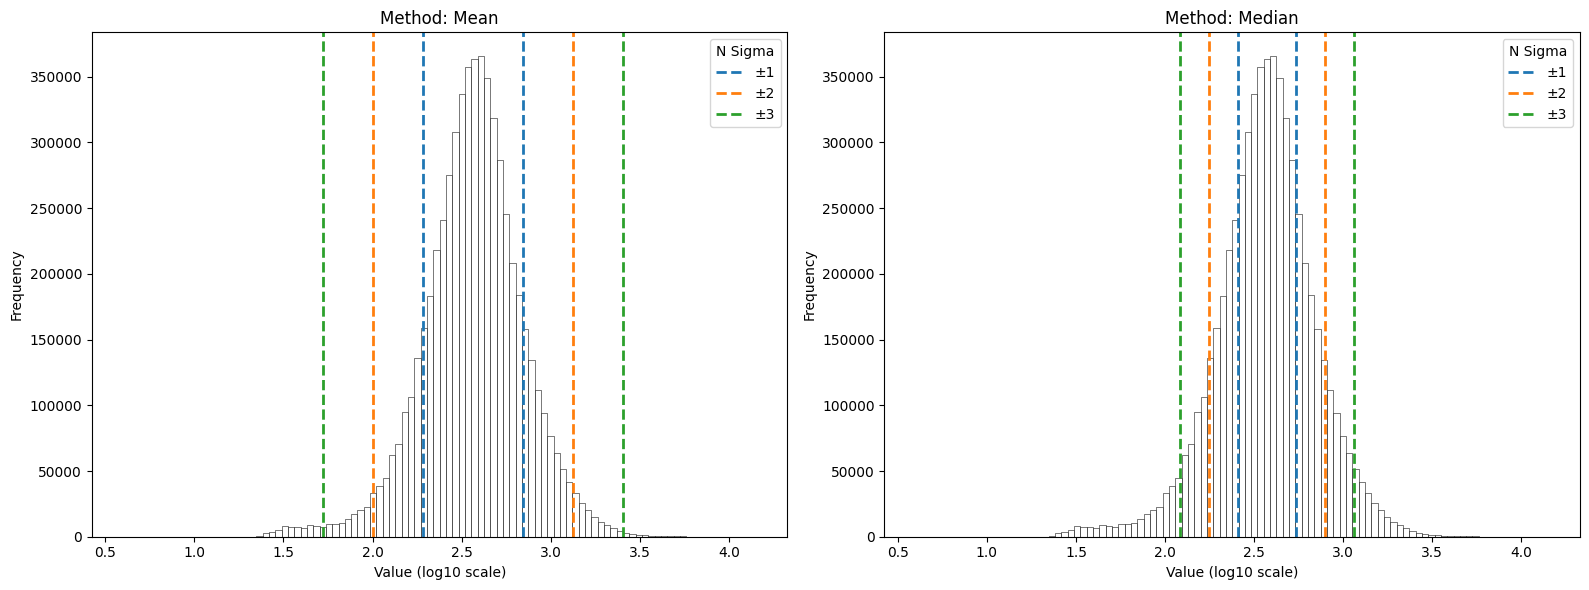

In [6]:
extreme_cutoff = ExtremeCutoff(values=adata.obs["cell_size"])
print(extreme_cutoff)

extreme_cutoff.test_cutoffs(n_sigmas=list(range(1, 6)))
fig, ax = extreme_cutoff.plot_cutoffs(show=True)

In [7]:
# Mask for filtering cells based on cell size (True = keep, False = filter out)
mask_size = extreme_cutoff.filter_values(
    method="median", n_sigma_lower=3, n_sigma_upper=3
)

print(f"Filtering {np.sum(~mask_size):,} cells based on cell_size")

+-------------+----------+------------+---------------+
|  Threshold  |   Cutoff |   Filtered |   Filtered(%) |
|-------------+----------+------------+---------------|
|    Lower    |   119.59 |    270,300 |         4.49% |
|    Upper    |  1152.76 |    211,410 |         3.51% |
|    Total    |          |    481,710 |            8% |
+-------------+----------+------------+---------------+
Filtering 481,710 cells based on cell_size


### 02. Nuclear Intensity Filter

Since our single-cell data is generated based on segmentation masks, we might have a lot of “cells”, which are truly segmentation artifacts. We want to remove those artifacts first. The first thing to do is naturally to quantify how many observations have 0 nuclear marker signal and filter them out.

In [8]:
# Mask for filtering cells with zero DAPI signal (True = keep, False = filter out)
mask_dapi_0 = (adata[:, "DAPI"].X > 0).flatten()

print(f"Filtering {np.sum(~mask_dapi_0):,} cells with zero DAPI signal")

Filtering 2,133 cells with zero DAPI signal


Then, we will need to check the distribution of the nuclear channel, DAPI in this case, to see if there are any cells with suspiciously low nuclear marker signals. 

Upon examining the distribution, one thing to note is that we can see the nuclear marker signal for all FOVs align pretty well. That’s a good thing and that’s what you should be seeing in most cases, if the experiment is done well. Of course, there might be some biological factors that can make some FOV’s nuclear signal stronger or weaker. When you see abnormality, always check the raw image data first before you decided if you want to throw out the data or not.

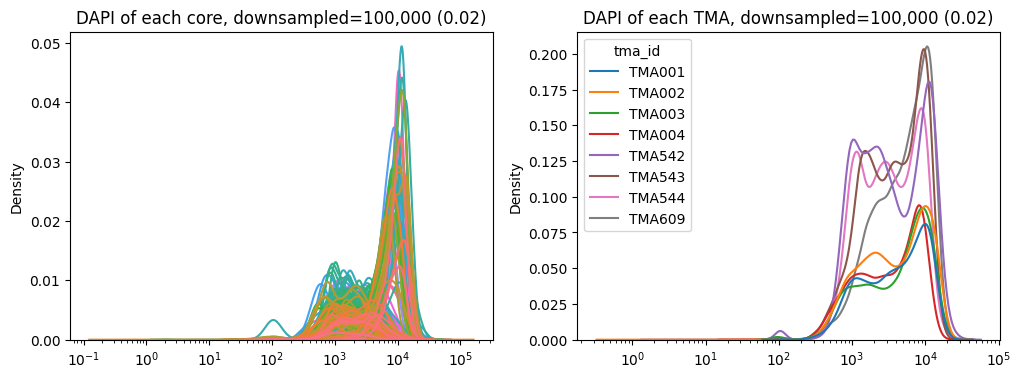

In [9]:
# Downsample cells for visualization
sample_size = 100000
adata_sm = _downsample_cells(adata[mask_dapi_0], sample_size=sample_size, seed=81)
tag_downsample = f"downsampled={sample_size:,} ({sample_size / adata.n_obs:.2f})"

# Plot DAPI distributions across cores and TMAs
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
sns.kdeplot(
    x=adata_sm[:, "DAPI"].X.flatten(),
    hue=adata_sm.obs["core_id"],
    log_scale=(True, False),
    legend=False,
    ax=ax,
)
ax.set_title(f"DAPI of each core, {tag_downsample}")

ax = axes[1]
sns.kdeplot(
    x=adata_sm[:, "DAPI"].X.flatten(),
    hue=adata_sm.obs["tma_id"],
    log_scale=(True, False),
    legend=True,
    ax=ax,
)
ax.set_title(f"DAPI of each TMA, {tag_downsample}")

plt.show()


From the distribution, we can see there are some cells with extremely low nuclear marker signal. These cells are likely to be segmentation artifacts or dead cells, which we want to remove from further analysis.

The outliers should be examined more carefully in combination with other markers because

- It can be that they just have high/low nuclear marker signal but other markers stained normally.
- It can be that they have extremely high/low marker signal overall.

Only in the 2nd case should we consider removing those cells. Since the marker intensities are not yet normalized and it may not be comparable across different FOVs, we will use DBSCAN within each FOV to detect potential outlier cells within each FOV. 

However, for the purpose of this tutorial, we will just drop those cells outside `median - 3 * mad`. And the upper end outliers are generally of less concern. 

More robust outlier detection methods will be updated later.

ExtremeCutoff(n=6022423, log_mean=3.56, log_std=0.43, log_median=3.61, log_mad=0.35)
+-----------+----------+---------------------+----------------------+---------------------+
|  N Sigma  |  Method  |   Lower (Filtered%) |    Upper (Filtered%) |   Total (Filtered%) |
|-----------+----------+---------------------+----------------------+---------------------|
|     1     |   mean   |     1357.73 (19.6%) |      9743.46 (19.2%) |    11101.19 (38.9%) |
|     1     |  median  |     1809.54 (27.6%) |      9136.13 (22.4%) |      10945.67 (50%) |
|     2     |   mean   |      506.37 (1.66%) |    26094.72 (0.031%) |    26601.08 (1.69%) |
|     2     |  median  |      804.95 (6.65%) |     20525.27 (0.21%) |    21330.22 (6.86%) |
|     3     |   mean   |     188.46 (0.235%) |        69883.49 (0%) |   70071.95 (0.235%) |
|     3     |  median  |     357.76 (0.535%) | 46110.61 (4.98e-05%) |   46468.37 (0.535%) |
|     4     |   mean   |     69.75 (0.0393%) |       187150.10 (0%) | 187219.85 (0.0393

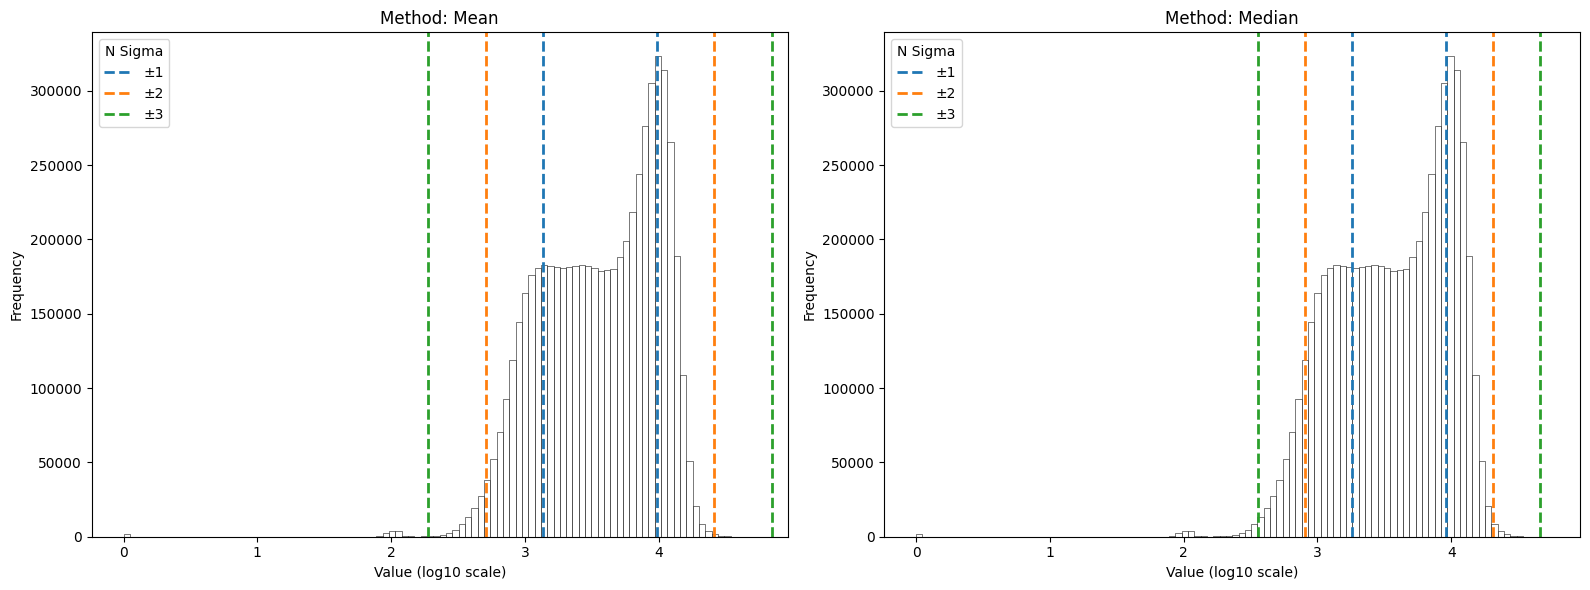

In [10]:
extreme_cutoff = ExtremeCutoff(values=adata[:, "DAPI"].X.flatten())
print(extreme_cutoff)

extreme_cutoff.test_cutoffs(n_sigmas=list(range(1, 6)))
fig, ax = extreme_cutoff.plot_cutoffs(show=True)

In [11]:
# Mask for filtering cells based on nuclear intensity (True = keep, False = filter out)
mask_dapi = extreme_cutoff.filter_values(
    method="median", n_sigma_lower=3, filter_upper=False
)

print(f"Filtering {np.sum(~mask_dapi):,} cells based on nuclear intensity")


+-------------+----------+------------+---------------+
|  Threshold  |   Cutoff |   Filtered |   Filtered(%) |
|-------------+----------+------------+---------------|
|    Lower    |   357.76 |     32,237 |        0.535% |
|    Upper    | 53194.73 |          0 |            0% |
|    Total    |          |     32,237 |        0.535% |
+-------------+----------+------------+---------------+
Filtering 32,237 cells based on nuclear intensity


### 03. Apply the Filters

In [12]:
print("Before filtering, AnnData object:")
print(adata)

# Apply the Filters
adata_filtered = adata[mask_size & mask_dapi & mask_dapi_0].copy()

# Store the raw data before preprocessing
adata_filtered.layers["scale_size"] = adata_filtered.X.copy()

print("\nFiltered AnnData object:")
print(adata_filtered)

Before filtering, AnnData object:
AnnData object with n_obs × n_vars = 6022423 × 45
    obs: 'Unnamed: 0', 'cell_id', 'cell_size', 'y_cent', 'x_cent', 'dst_register', 'src_register', 'core_id', 'CD68', 'tma_id'

Filtered AnnData object:
AnnData object with n_obs × n_vars = 5516051 × 45
    obs: 'Unnamed: 0', 'cell_id', 'cell_size', 'y_cent', 'x_cent', 'dst_register', 'src_register', 'core_id', 'CD68', 'tma_id'
    layers: 'scale_size'


## Nucleus Marker Signal Normalization

This step is to correct the region-to-region (in this case, core-to-core) variation of markers to make the same marker more comparable across different regions (in this case, cores).

Rationale: In other data, we observed that the nucleus signal is positively correlated with most markers, which means that if a region has higher nucleus signal, the signal of other markers of that region would also tend to be higher.

In [13]:
nucleus_signal_normalization(
    adata_filtered,
    col_data_id="core_id",
    marker_nucleus="DAPI",
    method="median",
    inplace=True,
)

print(adata_filtered)
print_processing_history(adata_filtered)

Nucleus Normalization:   0%|          | 0/162 [00:00<?, ?it/s]

Nucleus Normalization: 100%|██████████| 162/162 [00:07<00:00, 21.74it/s]

AnnData object with n_obs × n_vars = 5516051 × 45
    obs: 'Unnamed: 0', 'cell_id', 'cell_size', 'y_cent', 'x_cent', 'dst_register', 'src_register', 'core_id', 'CD68', 'tma_id', 'nucleus_norm_factor'
    uns: 'processing_history'
    layers: 'scale_size'

Processing History:

1. nucleus_signal_normalization
   Timestamp: 2025-12-06T17:00:04.966955
   Parameters:
      col_data_id: core_id
      marker_nucleus: DAPI
      method: median




A tracker of the processing steps is stored in the `uns` attribute of the `AnnData` object. You can use the `print_processing_history` function to print out the history of processing steps applied to the data. Any duplicated processing steps will be stopped to avoid redundant computation, unless you set `skip_check=True` to force the processing step to be applied again.

In [14]:
try:
    nucleus_signal_normalization(
        adata_filtered,
        col_data_id="core_id",
        marker_nucleus="DAPI",
        method="median",
        inplace=True,
    )
except Exception as e:
    print(f"Error: {e}")


Error: nucleus_signal_normalization has already been applied with parameters: {'col_data_id': 'core_id', 'marker_nucleus': 'DAPI', 'method': 'median'}. Set skip_check=True to bypass this check.


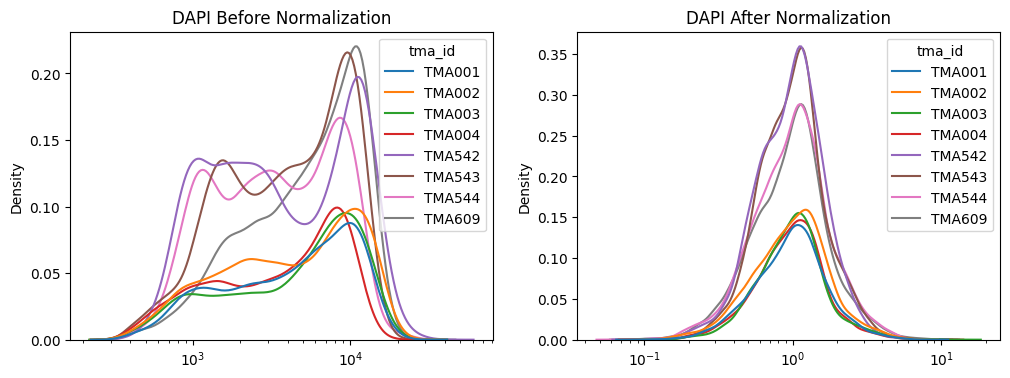

In [15]:
# Downsample cells for visualization
adata_sm = _downsample_cells(adata_filtered, sample_size=100000)

# Visualize DAPI distributions before and after normalization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
sns.kdeplot(
    x=adata_sm[:, "DAPI"].layers["scale_size"].flatten(),
    hue=adata_sm.obs["tma_id"],
    log_scale=(True, False),
    legend=True,
    ax=ax,
)
ax.set_title("DAPI Before Normalization")

ax = axes[1]
sns.kdeplot(
    x=adata_sm[:, "DAPI"].X.flatten(),
    hue=adata_sm.obs["tma_id"],
    log_scale=(True, False),
    legend=True,
    ax=ax,
)
ax.set_title("DAPI After Normalization")

plt.show()

## Arcsinh (Inverse Hyperbolic Sine) Transformation

This step will make the distribution of the markers less skewed and create a bimodal distribution whose peaks and neighboring masses can be easily interpreted as the positive and negative cells for that marker. We will show CD45 as an example here.

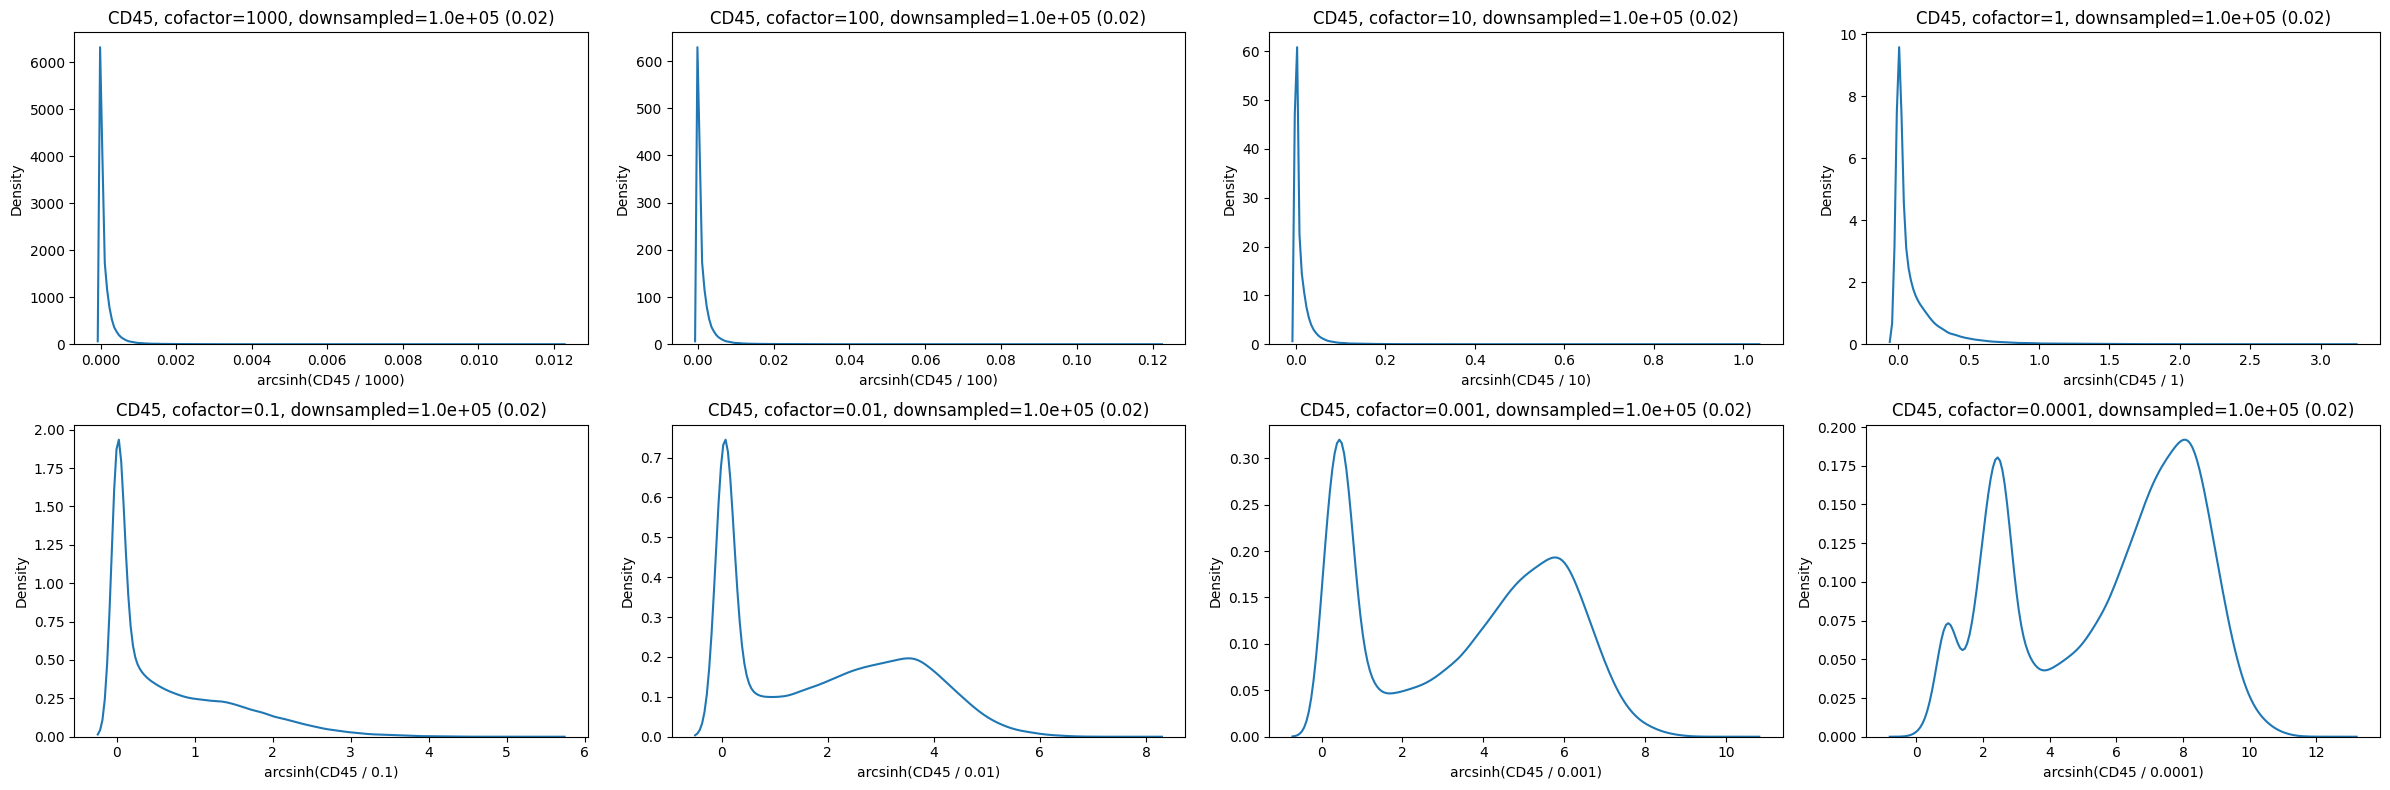

In [16]:
marker_name = "CD45"
fig, axes = plot_arcsinh_transformation(
    adata_filtered[adata_filtered[:, marker_name].X.flatten() > 0],
    marker_name,
    hue=None,
    nrow=2,
    sample_size=100000,
    legend=False,
    show=True,
)
# Filter out cells with zero CD45 signal for visualization, as the x-axis is log-scaled

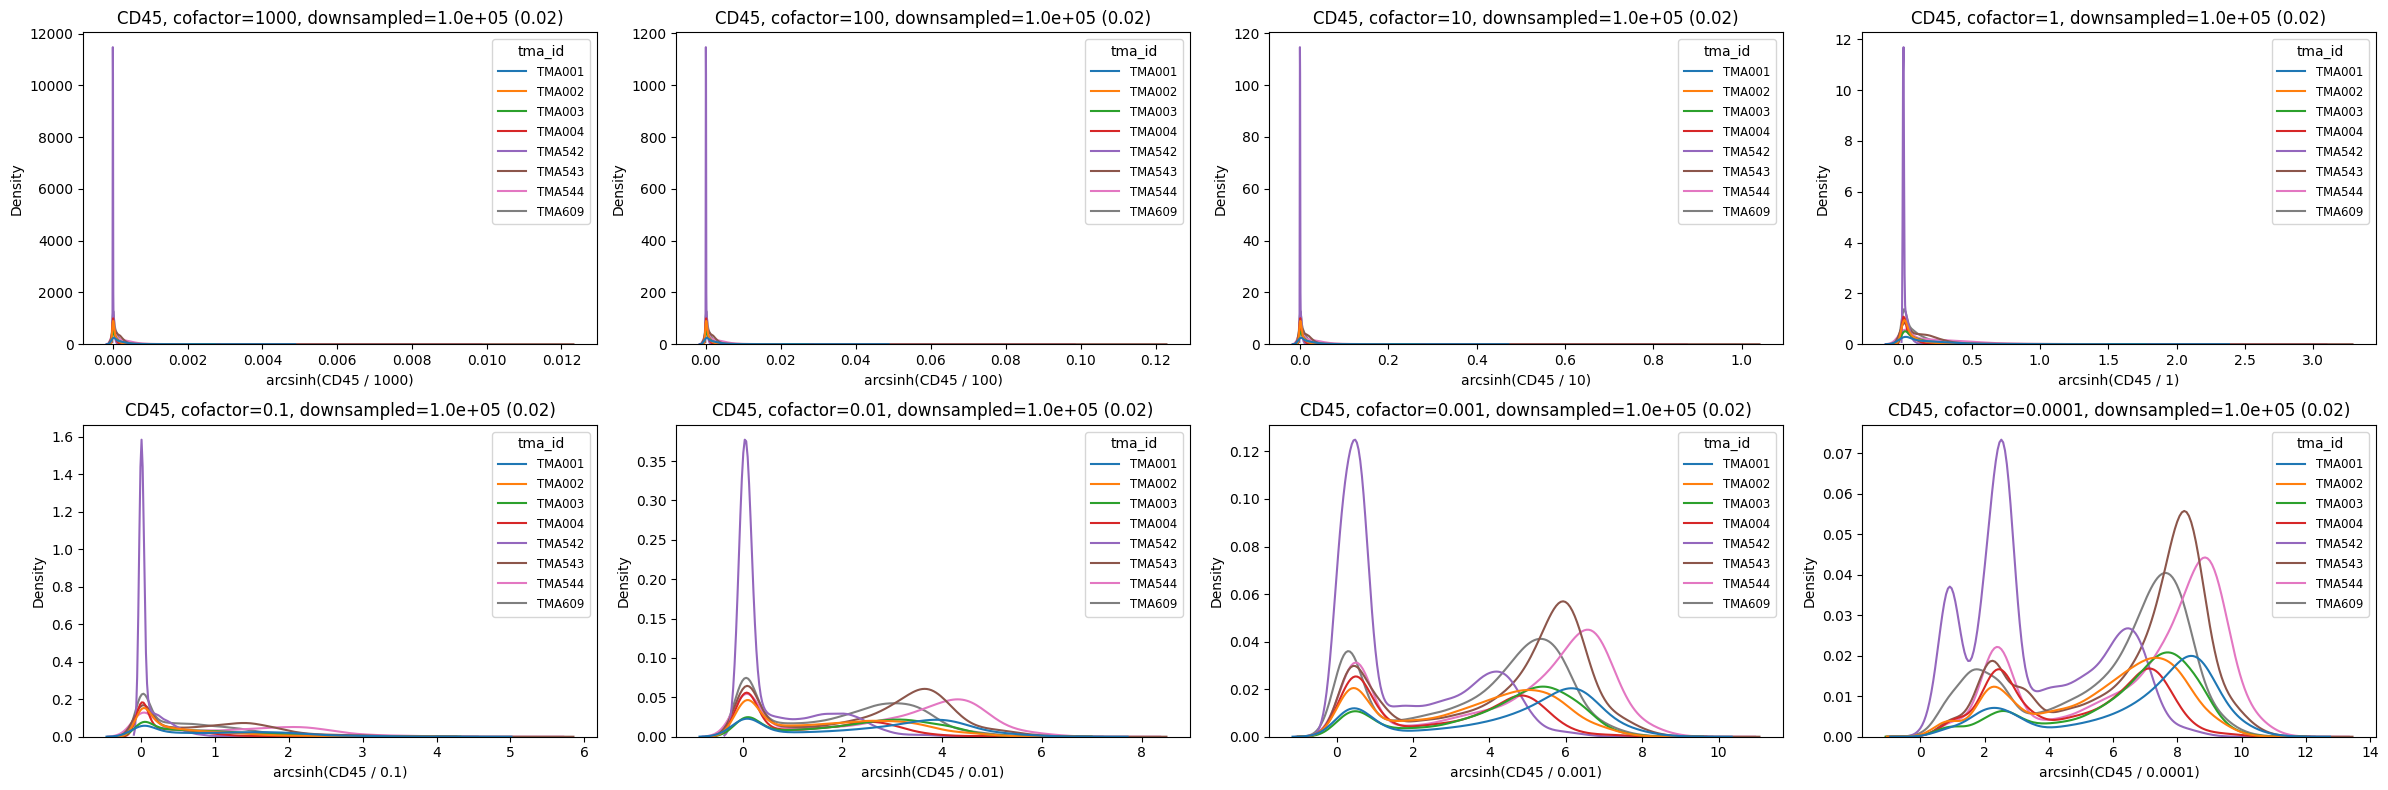

In [17]:
marker_name = "CD45"
fig, axes = plot_arcsinh_transformation(
    adata_filtered[adata_filtered[:, marker_name].X.flatten() > 0],
    marker_name,
    hue="tma_id",
    nrow=2,
    sample_size=100000,
    show=True,
)

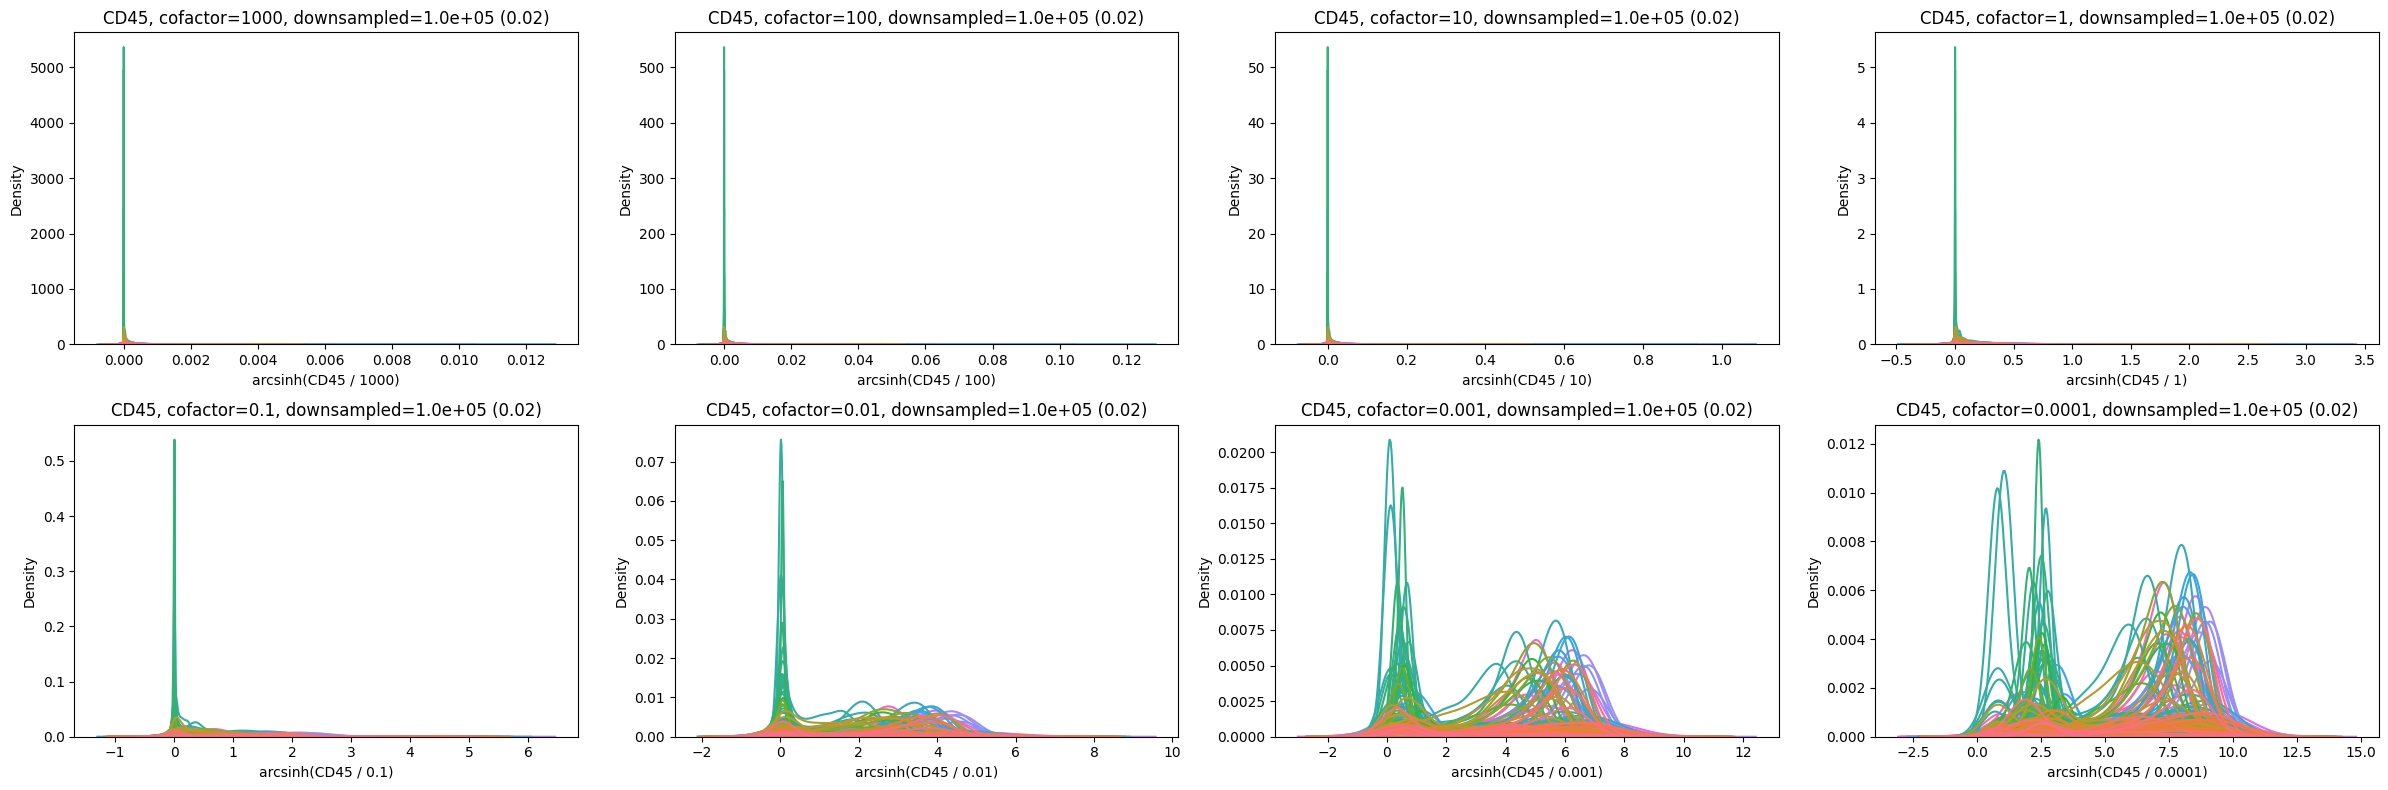

In [18]:
marker_name = "CD45"
fig, axes = plot_arcsinh_transformation(
    adata_filtered[adata_filtered[:, marker_name].X.flatten() > 0],
    marker_name,
    hue="core_id",
    nrow=2,
    sample_size=100000,
    legend=False,
    show=True,
)


For this dataset, the cofactor of 0.01 seems to be optimal. Hence, we will proceed with the arcsinh transformed data with cofactor 0.01.

In [19]:
arcsinh_transformation(adata_filtered, cofactor=0.01, inplace=True)

print(adata_filtered)
print_processing_history(adata_filtered)

AnnData object with n_obs × n_vars = 5516051 × 45
    obs: 'Unnamed: 0', 'cell_id', 'cell_size', 'y_cent', 'x_cent', 'dst_register', 'src_register', 'core_id', 'CD68', 'tma_id', 'nucleus_norm_factor'
    uns: 'processing_history'
    layers: 'scale_size'

Processing History:

1. nucleus_signal_normalization
   Timestamp: 2025-12-06T17:00:04.966955
   Parameters:
      col_data_id: core_id
      marker_nucleus: DAPI
      method: median

2. arcsinh_transformation
   Timestamp: 2025-12-06T17:01:15.073126
   Parameters:
      cofactor: 0.01




## Global Quantile Normalization

This step will transform the data to have range [0,1] based on a pair of chosen percentiles ($P_{low}$, $P_{high}$). The values below $P_{low}$ will be set to 0, and the values above $P_{high}$ will be set to 1. The values in between will be scaled linearly between 0 and 1.

$$
X_{norm} = \frac{X - X_{P_{low}}}{X_{P_{high}} - X_{P_{low}}}
$$

Where:
- $X$ is the original value
- $X_{P_{low}}$ is the value at the $P_{low}$ percentile
- $X_{P_{high}}$ is the value at the $P_{high}$ percentile
- $X_{norm}$ is the normalized value in range [0, 1]

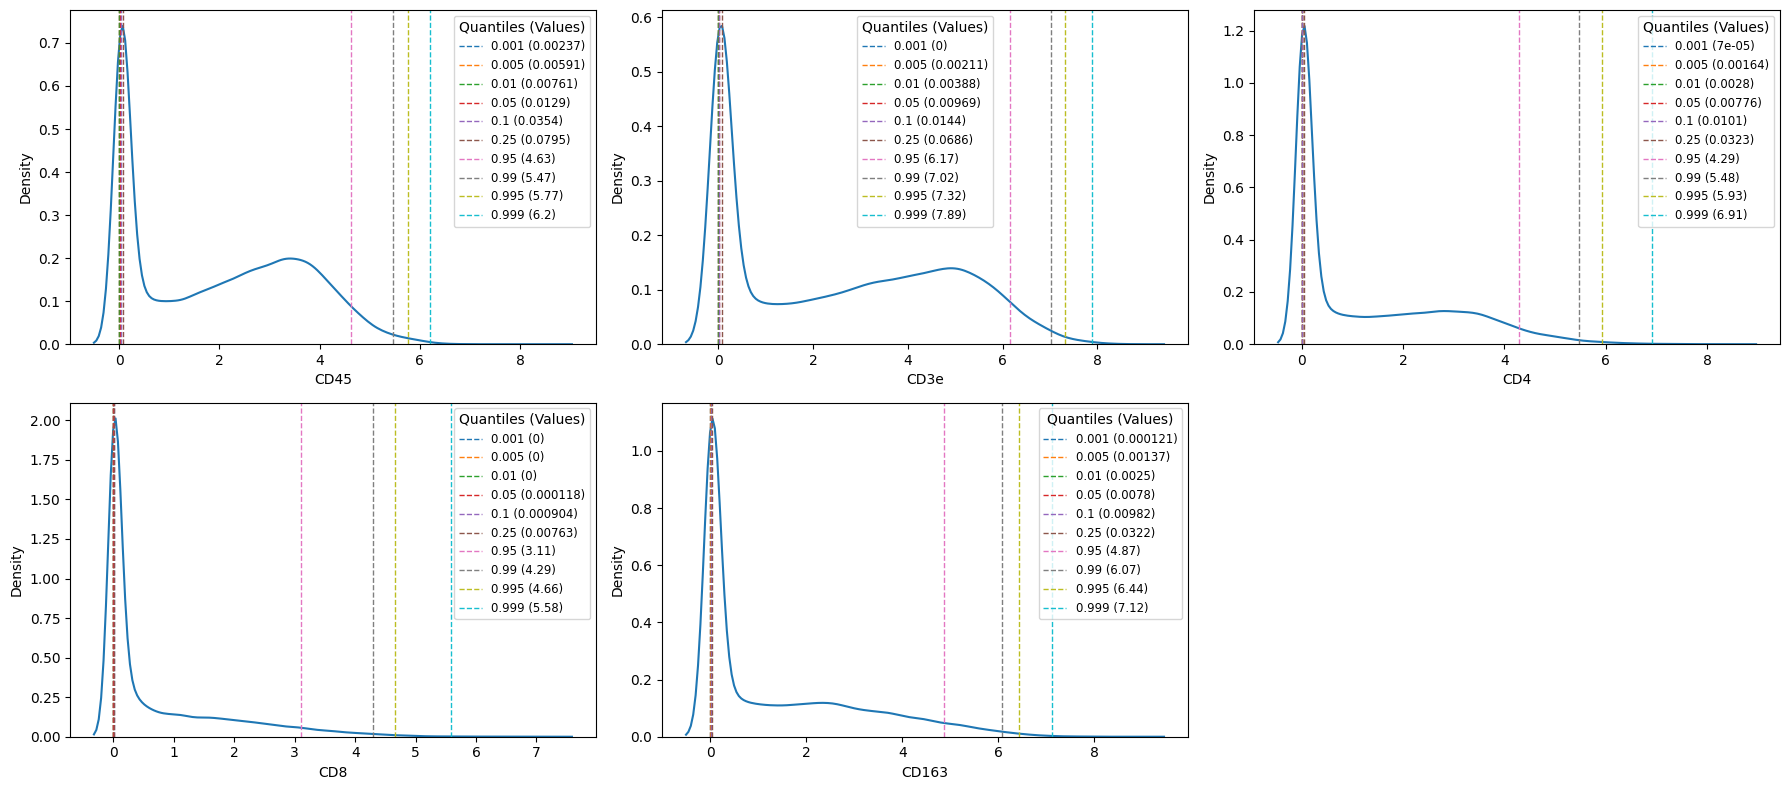

In [20]:
fig, axes = plot_quantile_normalization(
    adata_filtered,
    ["CD45", "CD3e", "CD4", "CD8", "CD163"],
    quantiles=[0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.95, 0.99, 0.995, 0.999],
    sample_size=100000,
    nrow=2,
)


In [21]:
quantile_normalization(
    adata_filtered,
    min_quantile=0.1,
    max_quantile=0.999,
    inplace=True,
)

print(adata_filtered)
print_processing_history(adata_filtered)


Quantile Normalization: 100%|██████████| 45/45 [00:11<00:00,  3.88it/s]

AnnData object with n_obs × n_vars = 5516051 × 45
    obs: 'Unnamed: 0', 'cell_id', 'cell_size', 'y_cent', 'x_cent', 'dst_register', 'src_register', 'core_id', 'CD68', 'tma_id', 'nucleus_norm_factor'
    uns: 'processing_history'
    layers: 'scale_size'

Processing History:

1. nucleus_signal_normalization
   Timestamp: 2025-12-06T17:00:04.966955
   Parameters:
      col_data_id: core_id
      marker_nucleus: DAPI
      method: median

2. arcsinh_transformation
   Timestamp: 2025-12-06T17:01:15.073126
   Parameters:
      cofactor: 0.01

3. quantile_normalization
   Timestamp: 2025-12-06T17:01:31.847404
   Parameters:
      min_quantile: 0.1
      max_quantile: 0.999
      equal_return: 0.0




As for tunning the lower and upper bound for difficult markers, unfortunately, the current way is to set some initial values to start with and compare the signal image to the raw image, with your adjustments to show only the true signals. If the two corresponds very well, you are done. Otherwise, you will know if you need to allow for higher signals or you need to cut out more lower end signals by looking at them. Sometimes, different ($P_{low}$ and $P_{high}$) need to be set for different markers. Therefore, you should check all the markers that you care about before you proceed to clustering and all the downstream analysis.

## Save the Preprocessed Data

In [22]:
adata.write_h5ad("preprocessed_data.h5ad")